# About this Notebook

Within this notebook, log data from an online plattform is used to evaluate a new feature. The plattform can be used to book appointments in different locations (like barbers). With the new feature, users can see which venues are top-ranked. The data ranges from 01/09/2017 until 14/11/2017. The new feature was introduced on the 4th of October 2017.

Two **tables** are available:
* Venues: List of venues with information about whether they are top-ranked or not
* Events: Log data from user visits

The following **questions** should be answered:

*Business-Perspective*:
* Does the new feature increase the probability that a booking process is completed?

*Regarding the user experience*:
* Does the new feature help to decrease the search time?
* Do users find the recommendations useful? &rarr; Does the number of bookings increase if a venue is top-rated?

The following **assumptions** are made:
* There is no substantial change in the user behaviour across the months September to November (otherwise the data from the two groups must have been collected at the same time)

First, the two tables are loaded:

In [108]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()


# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# read data
events_df = pd.read_csv("GB_events.csv")
venues_df = pd.read_csv("ldn_venues.csv")

# Data Exploration
Taking a first quick look at the events-table.

There are almost 3 milion log-events from 91.957 sessions.
Within one session, there can be multiple bookings (every event with the page-type-category *Confirmed* is considered as a new booking if the previous page-type-category was different). Therefore it won't make sense to measure the conversion rate using the sessions, instead the number of successfull bookings shall be used.

# events: 2968899

# sessions: 91957

Index(['Unnamed: 0', 'X', 'session_id', 'collector_time', 'event',
       'filtered_top_rated', 'page_type_category', 'venue_id'],
      dtype='object')
                             session_id  confirmation_counts
1720   178d9bce60af484258b14f17937d85a4                   14
5247   45b279428c6ab3c088cc3f65711dd7e5                   14
15564  cf41e88ff397313428ebb23e47b16d08                   13


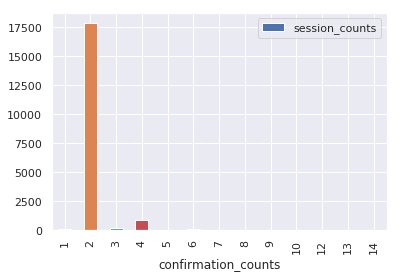

In [109]:
print("# events: %s" % len(events_df) + "\n")
print("# sessions: %s" % len(events_df.groupby("session_id").count()) + "\n")
print(events_df.columns)

# are there multiple bookings/confirmations per session?
conf_df = events_df[(events_df['page_type_category'] == 'Confirmed') & (events_df['event'] == 'page_view')][['page_type_category', 'session_id']] \
    .groupby("session_id", as_index=False) \
    .count() \
    .rename(columns={'page_type_category': 'confirmation_counts'})
print(conf_df.sort_values('confirmation_counts', ascending=False).head(3))
    
conf_df = conf_df.groupby("confirmation_counts", as_index=False).count().rename(columns={'session_id': 'session_counts'})

conf_df.plot.bar(x='confirmation_counts', y='session_counts')

Check of the venue-table.

One can see that only 982 venues are included, while there are 8.426 distinct venue-ids in the event-table.

In [3]:
print("Number of distinct venues in venues-table: " + str(len(set(venues_df['venue_id']))))
top_rated = venues_df[venues_df['top_rated_info'] == "Top rated"]
print("Number of top-rated venues in venues-table: %s (%s)" % (len(top_rated), (len(top_rated)/len(venues_df))))

event_venues = set(events_df['venue_id'])
print("Number of distinct venue ids in events-table: " + str(len(event_venues)))
venues = set(venues_df['venue_id'])
diff_venue_ids = list(event_venues - venues)
print(len(diff_venue_ids))
print("Only %s of all venues available" % (len(venues)/len(event_venues)))

Number of distinct venues in venues-table: 982
Number of top-rated venues in venues-table: 60 (0.06109979633401222)
Number of distinct venue ids in events-table: 8426
7541
Only 0.11654403038215048 of all venues available


# Data Preparation
In order to check whether the conversion rate increased with the new feature, a booking table has to be generated.

In this notebook, a booking is defined as the cycle from the session start to the first confirmation-event. If there is no confirmation (user did not book), the booking ends with the session end. If there are multiple bookings within a session, the a booking ends with the confirmation and the next booking starts with the next event. 

First, I will check for missing values and do some transformations on the data.
## Transformations

In [4]:
events_df['filtered_top_rated'] = (events_df['filtered_top_rated'] == 'y')

# replace top_rated_info by boolean field
venues_df['top_rated'] = venues_df['top_rated_info'].apply(lambda x: True if x == "Top rated" else False)
venues_df2 = venues_df.drop('top_rated_info', axis=1)
print(venues_df.groupby('top_rated').count())

           Unnamed: 0  venue_id  purchasable_date  churn_date  top_rated_info
top_rated                                                                    
False             922       922               922         132               0
True               60        60                60           2              60


## Check missing values
In the event-table, the only the venue-id has missing values since this data is only recorded for a few steps in the order process. The missing values will be filled once the booking table is ready.

In the venue table, only the churn_data-column has missing values (if the venue did not leave the platform, there is no data in the table). This will be ignored since the feature will not be used in the next steps.

In [5]:
events_cnt = len(events_df)
for column in events_df.columns:
    print(column + ": " + str(len(events_df.dropna(axis=0, subset=[column]))/events_cnt *100) + "%")
print("")

venues_cnt = len(venues_df2)
for column in venues_df2.columns:
    print(column + ": " + str(len(venues_df2.dropna(axis=0, subset=[column]))/venues_cnt *100) + "%")


Unnamed: 0: 100.0%
X: 100.0%
session_id: 100.0%
collector_time: 100.0%
event: 100.0%
filtered_top_rated: 100.0%
page_type_category: 100.0%
venue_id: 49.13336560118751%

Unnamed: 0: 100.0%
venue_id: 100.0%
purchasable_date: 100.0%
churn_date: 13.64562118126273%
top_rated: 100.0%


## Create bookingcycle-table
The data is ready to create the booking table.

A new cycle starts with a new session or after a previous booking within the same session and ends when a user reaches the confirmation page or when the session ends.

The table will have the follwing schema:
- ID: sessionid + starttime
- Starttime
- Endtime
- Successful (ended with confirmation) [bool]
- ratings available [bool]
- Time to confirmation in seconds [int]
- Time to last time-selection in seconds [int] -> search time

To find the starts and ends of a cycle, each potential start (session start or event after confirmation) and end (session end or confirmation) will be labeled accordingly.

In [6]:
# add some additional columns as preparation for the labeling
session_ids = set(events_df['session_id'])
booking_cycles = pd.DataFrame()
session_starts = events_df.groupby('session_id')['X'].min()
session_ends = events_df.groupby('session_id')['X'].max()

events_df['prev_page_type'] = events_df.groupby('session_id')['page_type_category'].shift(1)
events_df['next_page_type'] = events_df.groupby('session_id')['page_type_category'].shift(-1)


def label_event(category, prev_category, next_category):
    """
    Labels an event as start or end of a booking cycle if applicable.
    """
    if(category == 'Confirmed'):
        return 'confirmation_end'
    elif((prev_category == 'Confirmed') & (category != 'Confirmed')):
        return 'booking_start'
    elif(pd.isna(prev_category)):
        return 'booking_start'
    elif(pd.isna(next_category)):
        return 'booking_end'
    else:
        return ""

# label every event
events_df['label'] = events_df \
    .apply(lambda x: label_event(x['page_type_category'], x['prev_page_type'], x['next_page_type']), axis=1)

The cycles are created by taking every start-event together with their next end-event. After that, some additional columns are added:
* Start_time: Time of the start-event
* End_time: Time of the end-event
* Start_ID: Id of the start-event
* Cycle_time_seconds: Seconds between start and end time
* Cycle_ID: String created by concatenating session_id and start time
* Confirmed: True if the cycle ended with a confirmation
* Feature_available: Indicates whether the new feature is available or not (true for every cycle that starts after midnight on the 4th of October 2017)

In [7]:
# create booking cycle table
booking_events = events_df[events_df['label'] != ""] 
booking_events[['end_id', 'next_time', 'next_label']] = \
    booking_events.groupby('session_id')[['X', 'collector_time', 'label']].shift(-1)

booking_cycles = booking_events[(booking_events['label'] == 'booking_start') & \
                                ((booking_events['next_label'] == 'booking_end') | \
                                 (booking_events['next_label'] == 'confirmation_end'))]

booking_cycles['start_time'] = pd.to_datetime(booking_cycles['collector_time'])
booking_cycles['end_time'] = pd.to_datetime(booking_cycles['next_time'])
booking_cycles['start_id'] = booking_cycles['X']
booking_cycles['cycle_time_seconds'] = (booking_cycles['end_time'] - booking_cycles['start_time']).dt.total_seconds()
booking_cycles['confirmed'] = booking_cycles['next_label'] == 'confirmation_end'
booking_cycles['cycle_id'] = booking_cycles['session_id'] + str(booking_cycles['start_time'])

# add column that indicates whether the new top rated-feature was available
booking_cycles['feature_available'] = booking_cycles['start_time'] >= "2017-10-04 00:00:00"

# remove redundant columns
booking_cycles = booking_cycles[['cycle_id', 'session_id', 'start_time', 'end_time', 'cycle_time_seconds', \
                                 'confirmed', 'feature_available', 'start_id', 'end_id']]

In [8]:
"""testing the results on a session with multiple bookings
assert(len(booking_cycles[booking_cycles['cycle_time_seconds'] < 0]) == 0)
print((booking_cycles[booking_cycles['session_id'] == '72d226e3488091bbcc5381466400dc0b']\
       [['start_time', 'end_time', 'start_id', 'end_id', 'confirmed']]))
print("")
for i, row in (events_df[(events_df['session_id'] == '72d226e3488091bbcc5381466400dc0b')]\
      [['collector_time', 'X', 'page_type_category']]).iterrows():
    print(row[['page_type_category', 'collector_time', 'X']])"""

'testing the results on a session with multiple bookings\nassert(len(booking_cycles[booking_cycles[\'cycle_time_seconds\'] < 0]) == 0)\nprint((booking_cycles[booking_cycles[\'session_id\'] == \'72d226e3488091bbcc5381466400dc0b\']       [[\'start_time\', \'end_time\', \'start_id\', \'end_id\', \'confirmed\']]))\nprint("")\nfor i, row in (events_df[(events_df[\'session_id\'] == \'72d226e3488091bbcc5381466400dc0b\')]      [[\'collector_time\', \'X\', \'page_type_category\']]).iterrows():\n    print(row[[\'page_type_category\', \'collector_time\', \'X\']])'

### Additional features:
* last_venue_viewed: Which venue did the user choose if he placed an order?
* venue_top_rated: Was the venue among the higher ranked venues?
* search_time: Time from the start of the booking to the last time-selection event

In [9]:
# for every booking that ended with a confirmation, get the latest time-selection event
time_selection_df = events_df[events_df['page_type_category'] == 'Time-selection Page']\
    [['X', 'page_type_category', 'session_id', 'venue_id', 'collector_time']]
bookings_with_times = booking_cycles.merge(time_selection_df, on='session_id', how='left')

def check_time(idx, start_idx, end_idx):
    if pd.isna(idx):
        return None
    elif((end_idx >= idx) & (start_idx <= idx)):
        return idx
    else:
        return None
    
# bookings_with_times['relevant_time'] = (bookings_with_times['end_id'] >= bookings_with_times['X']) & \
#                                        (bookings_with_times['start_id'] <= bookings_with_times['X']) 
bookings_with_times['X'] = bookings_with_times.apply(lambda x: check_time(x['X'], x['start_id'], x['end_id']), axis=1)

bookings_with_times = bookings_with_times.groupby(list(booking_cycles.columns), as_index=False).max() 

# extract venue id of the latest venue viewed
bookings_with_venues = bookings_with_times.merge(time_selection_df, on='X', how='left')\
                        [['cycle_id', 'session_id_x', 'start_time', 'end_time', \
                        'cycle_time_seconds', 'confirmed', 'feature_available', \
                        'start_id', 'end_id', 'venue_id_y', 'collector_time_y']] \
                        .rename(columns={'venue_id_y': 'venue_id', 'session_id_x': 'session_id', \
                                         'collector_time_y': 'time_selector_time'})
        
venues_small = venues_df[['venue_id', 'top_rated']]

# add column that shows whether the viewed venue is top rated
bookings_with_venues = bookings_with_venues.merge(venues_small, on='venue_id', how='left')\
    .rename(columns={'venue_id': 'last_venue_viewed', 'top_rated': 'venue_top_rated'})
        
# add search time column (= time between start and last time selection)
bookings_with_venues['time_selector_time'] = pd.to_datetime(bookings_with_venues['time_selector_time'])
bookings_with_venues['search_time'] = (bookings_with_venues['time_selector_time'] - bookings_with_venues['start_time'])\
    .dt.total_seconds()
bookings_with_venues['search_time'] = bookings_with_venues\
    .apply(lambda x: x['search_time'] if pd.notna(x['search_time']) else x['cycle_time_seconds'], axis=1)

assert(len(bookings_with_venues) == len(booking_cycles))
assert(len(bookings_with_venues[bookings_with_venues['search_time'] < 0]) == 0)

In [10]:
# add column that shows whether the user used the top-rated filter
top_rated_events = events_df[events_df['filtered_top_rated'] == True][['session_id', 'X']]
"""
k = events_df
k['time'] = pd.to_datetime(k['collector_time'])
print(k[(k['filtered_top_rated'] == True) & (k['time'] <= pd.to_datetime("2017-10-04 00:00:00"))].sort_values('time'))
"""

bookings_with_top_rated = bookings_with_venues.merge(top_rated_events, on='session_id', how='left')
bookings_with_top_rated['rated_time_ok'] = bookings_with_top_rated \
    .apply(lambda x: check_time(x['X'], x['start_id'], x['end_id']), axis=1)
bookings_with_top_rated = bookings_with_top_rated[pd.notna(bookings_with_top_rated['rated_time_ok'])] \
    .groupby('cycle_id', as_index=False).count()
bookings_with_top_rated = bookings_with_top_rated[['cycle_id', 'rated_time_ok']]
# print((bookings_with_top_rated.groupby('cycle_id', as_index=False)['rated_time_ok'].head(2)))

cols = list(bookings_with_venues.columns)
bookings = bookings_with_top_rated.merge(bookings_with_venues, on='cycle_id', how='right')
bookings['filtered_top_ratings'] = pd.notnull(bookings['rated_time_ok'])
new_cols = cols + ['filtered_top_ratings']
bookings = bookings[new_cols]

assert(len(bookings) == len(bookings_with_venues))

# test: filter use may only occure after release
# assert(len(bookings[(bookings['filtered_top_ratings'] == True) & \
#                     (bookings['start_time'] < pd.to_datetime('2017-10-04 00:00:00'))]) == 0)

print(len(bookings))
assert(len(bookings) == len(booking_cycles))

print("Number of cycles with top-rated filtering: " + str(len(bookings[bookings['filtered_top_ratings'] == True])))

97010
Number of cycles with top-rated filtering: 1545


Since the filtering for top-rated venues does not seem to be so popular, I decided to create a plot where one can see how the usage of this feature developed. Obviously, most users did not find the feature so interesting.

Another thing that becomes visible here is that the majority of bookings is done during the week, while there are some dips on the weekends.

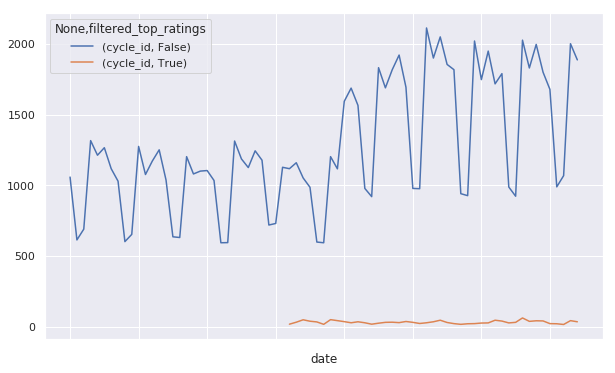

In [110]:
bookings['date'] = bookings['start_time'].dt.strftime('%m/%d/%Y')
fig, ax = plt.subplots(figsize=(10,6))
bookings[['date', 'filtered_top_ratings', 'cycle_id']].groupby(['date', 'filtered_top_ratings']).count().unstack().plot(ax=ax)

   hour  cycle_id
0    00       670
1    01       396
2    02       227
3    03       169
4    04       144
5    05       306
6    06       746
7    07      2046
8    08      5286
9    09      7895
10   10      9038
11   11      8287
12   12      8198
13   13      7886
14   14      7687
15   15      7429
16   16      5653
17   17      3985
18   18      3493
19   19      3997
20   20      4521
21   21      4302
22   22      3018
23   23      1631


[Text(0,0,'00'),
 Text(0,0,'01'),
 Text(0,0,'02'),
 Text(0,0,'03'),
 Text(0,0,'04'),
 Text(0,0,'05'),
 Text(0,0,'06')]

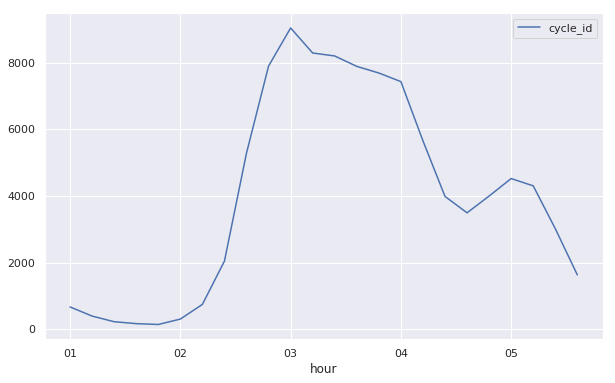

In [136]:
bookings['hour'] = bookings['start_time'].dt.strftime('%H')
hour_count = bookings[['hour', 'cycle_id']].groupby('hour').count().reset_index()[['hour', 'cycle_id']]
print(hour_count)
fig, ax = plt.subplots(figsize=(10,6))
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#bookings[['hour', 'cycle_id']].groupby('hour').count().plot(ax=ax)
hour_count.plot(x='hour', y='cycle_id', ax=ax)
ax.set_xticklabels(list(hour_count['hour']))

# Hypothesis Testing I
Question to be answered: *Does the new feature increase the probability of a completed booking?*

Metric: Number of completed bookings/Number of bookingcycles started

*H0: p_test - p_control >= 0* &rarr; difference between confirmation probability is equal or lower to zero.

*H1: p_test - p_control < 0* &rarr; difference between confirmation probability is greater than zero.

## Graphical Analysis
The graphic below shows that the total number of booking cycles almost doubled. It seems like also the conversion rate increased after the introduction of the new feature.

In the next step, I will use a hypothesis test to test whether there is a significant increase in the conversion rate after the introduction of the new feature.

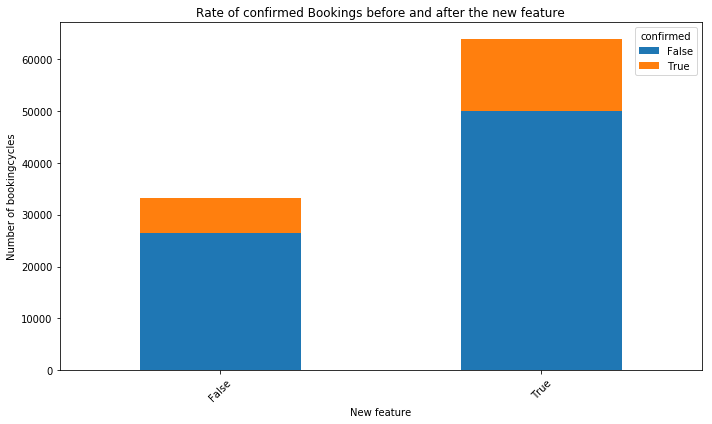

In [12]:
plot_cycles = booking_cycles
plot_cycles['confirmed_x'] = plot_cycles.apply(lambda x: 'confirmed' if x['confirmed'] else 'not confirmed', axis=1)
plot_cycles['new_feature'] = plot_cycles.apply(lambda x: 'available' if x['feature_available'] == True else 'not available', axis=1)

fig, ax = plt.subplots(figsize=(10,6))
plot_cycles.groupby(['feature_available', 'confirmed']).size().unstack().plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('New feature')
ax.set_ylabel('Number of bookingcycles')
ax.set_title("Rate of confirmed Bookings before and after the new feature")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

## Hypothesis Test 1: Step 1 - Calculate confirmation probabilities

The total number of booking cycles increased from 33.140 to 63.870. Also the probability for a confirmed booking (conversion rate) increased from 19.99% to 21.85%.

In the next step, these results will be used for an hypothesis test.

In [13]:
control_df = booking_cycles[booking_cycles['start_time'] < "2017-10-04 00:00:00"]
test_df = booking_cycles[booking_cycles['start_time'] >= "2017-10-04 00:00:00"]
conf_cntrl = control_df[control_df['confirmed'] == True]
conf_test = test_df[test_df['confirmed'] == True]
p_cntrl = len(conf_cntrl)/len(control_df)
p_test = len(conf_test)/len(test_df)
print("Probability for confirmation in control: " + str(p_cntrl))
print("Probability for confirmation in test: " + str(p_test) + "\n")

print("n_ctrl: " + str(len(control_df)))
print("n_test: " + str(len(test_df)))

print("Differences in probability: " + str(p_test - p_cntrl))

nconf_cntrl = control_df[control_df['confirmed'] == False]
nconf_test = test_df[test_df['confirmed'] == False]

Probability for confirmation in control: 0.1999094749547375
Probability for confirmation in test: 0.2184906842022859

n_ctrl: 33140
n_test: 63870
Differences in probability: 0.018581209247548414



## Hypothesis Test 1: Step 2 - Check statistical significance

Using the statistics of the two populations, a one-sided hypthesis is executed to validate the statistical significance of the difference in the conversion rate.

With a level of significance of 95%, the null-hypothesis (conversion rate in test set >= conversion rate on control set) can be rejected. Therefore, there seems to be a significant increase in the conversion rate after the introduction of the new feature.

In [14]:
# z-value for 95% (one-sided) = 1.65.
z_value = 1.65

diff_e = p_test - p_cntrl

se_cntrl = control_df['confirmed'].sem()
se_test = test_df['confirmed'].sem()

# pooled standard error:
se_pool = (se_cntrl**2 + se_test**2)**(1/2)

# margin error:
margin_error = se_pool * z_value

# check significance. H0 can be rejected since estimated difference greater than margin error.
print(diff_e > margin_error)

True


# Hypothesis Testing II
Question to be answered: *Does the new feature decrease the search time?*

Metric: Search time per successfull booking

*H0: dur_test - dur_cntrl <= 0* &rarr; difference between search times is equal or lower to zero.

*H1: dur_test - dur_cntrl > 0* &rarr; difference between search times is greater than zero.

Only successfull bookings will be considered here.

## Graphical analysis
After removing the outliers, there seems to be a slight tendency that the new feature helped decreasing the mean search time. This must be confirmed using a Welch test.

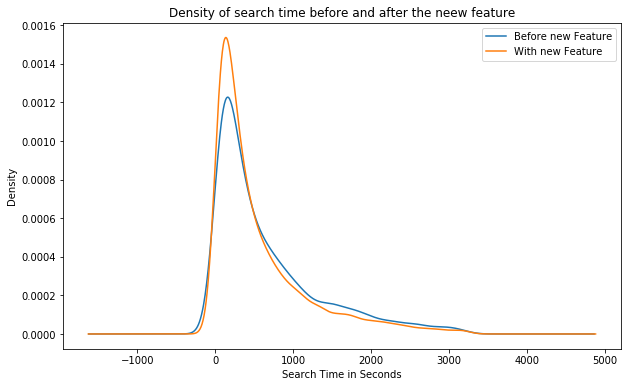

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
labels = list()
search_times = bookings[bookings['confirmed'] == True]
q = search_times['search_time'].quantile(0.98)
search_times = search_times[search_times['search_time'] < q]

for label, df in search_times[['feature_available', 'search_time']].groupby('feature_available'):
    if(label):
        l = "With new Feature"
    else:
        l = "Before new Feature" 
    df['search_time'].plot(kind="kde", ax=ax, label=l)
    
ax.set_xlabel('Search Time in Seconds')
ax.set_title("Density of search time before and after the neew feature")
plt.legend()

### Step 1 - Calculate duration distributions
Assumption: Search time is normally distributed.

In [16]:
success_bookings = bookings[bookings['confirmed'] == True]
control_df2 = success_bookings[success_bookings['start_time'] < "2017-10-04 00:00:00"]
test_df2 = success_bookings[success_bookings['start_time'] >= "2017-10-04 00:00:00"]
cntrl_mdur = control_df2['search_time'].mean()
test_mdur = test_df2['search_time'].mean()
print("Mean duration control: " + str(cntrl_mdur))
print("Mean duration test: " + str(test_mdur) + "\n")

print("n_ctrl: " + str(len(control_df)))
print("n_test: " + str(len(test_df)))

Mean duration control: 1111.5027924528301
Mean duration test: 674.7414546757435

n_ctrl: 33140
n_test: 63870


### Step 2 - Check statistical significance
A one-sided Welch-test is used to check H0. I chose the Welch-test here since the test does not require equal variances within the populations.

The H0 (search time with new feature >= search time without new feature) can be rejected.

In [17]:
# perform Welch-test
t, p = stats.ttest_ind(test_df2['search_time'], control_df2['search_time'], equal_var=False)

# since this is the result of a two-sided test, p has to be divided by 2
p = p/2
print("t-statistics: " + str(t))
print("p-value: " + str(p))

print(p < 0.05)

t-statistics: -1.9135406664910044
p-value: 0.027859601606500587
True


# Hypothesis Testing III
Question to be answered: *Does the new feature increase the probability of a booking for a top-rated venues?*

Metric: Number of completed bookings/Number of bookingcycles started
Limitation: Only information for a small number of venues available.

*H0: p_test - p_control >= 0* &rarr; difference between top-rated booking probability is equal or lower to zero.

*H1: p_test - p_control < 0* &rarr; difference between top-rated booking probability is greater than zero.

## Graphical analysis

Like in the analysis of the conversion rate, one can see a clear rise in the number of total bookings. But also the ratio of bookings in top-rated venues seems to be larger.

In the next step, this difference will be tested with an one-sided hypothesis test.

2699
Number of bookings for known venues: 2699


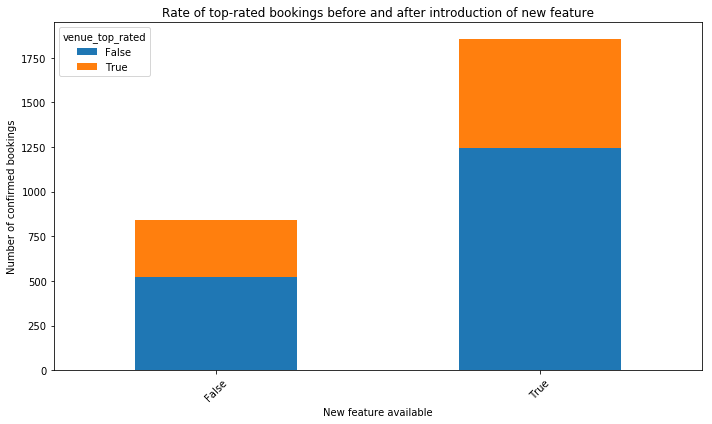

In [18]:
success_bookings = bookings[bookings['confirmed'] == True]
venue_bookings = success_bookings[pd.notnull(success_bookings['venue_top_rated'])]
print(len(venue_bookings))
print("Number of bookings for known venues: " + str(len(venue_bookings)))
fig, ax = plt.subplots(figsize=(10,6))
venue_bookings.groupby(['feature_available', 'venue_top_rated']).size().unstack().plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('New feature available')
ax.set_ylabel('Number of confirmed bookings')
ax.set_title('Rate of top-rated bookings before and after introduction of new feature')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

### Step 1 - Calculate booking probabilities

Before the introduction of the top-rated feature, the probability of a booking in a top-rated venue was 32.77%. With the new feature, a probability of 38.15% could be observed. 

The next step is to validate whether this result is statistically relevant in order to make sure that this is not just a random effect.

In [19]:
control_df3 = venue_bookings[venue_bookings['feature_available'] == True]
test_df3 = venue_bookings[venue_bookings['feature_available'] == False]
topr_cntrl3 = control_df3[control_df3['venue_top_rated'] == True]
print(len(topr_cntrl3))
topr_test3 = test_df3[test_df3['venue_top_rated'] == True]
print(len(topr_test3))
p_cntrl3 = len(topr_cntrl3)/len(control_df3)
p_test3 = len(topr_test3)/len(test_df3)
print("Probability for top-rated booking in control: " + str(p_cntrl3))
print("Probability for top-rated booking in test: " + str(p_test3) + "\n")

print("n_ctrl: " + str(len(control_df3)))
print("n_test: " + str(len(test_df3)))

608
322
Probability for top-rated booking in control: 0.32776280323450135
Probability for top-rated booking in test: 0.3815165876777251

n_ctrl: 1855
n_test: 844


### Step 2 - Check statistical significance

The H0 (probability for top-rated booking in test set >= probability in control set) can be rejected. The new feature seems to be useful for the users, since the probability for a booking in one of these venues increased.

In [20]:
# z-value for 95% (one-sided) = 1.65.
z_value = 1.65

diff_e3 = p_test3 - p_cntrl3

se_cntrl3 = control_df3['venue_top_rated'].sem()
se_test3 = test_df3['venue_top_rated'].sem()

# pooled standard error:
se_pool3 = (se_cntrl3**2 + se_test3**2)**(1/2)

# margin error:
margin_error3 = se_pool3 * z_value

# check significance. H0 can be rejected since estimated difference greater than margin error.
print(margin_error3)
print(diff_e3 > margin_error3)

0.032948388284755756
True
